# Task based paralellism using Dask, a NEXRAD example. 

In [129]:
import nexradaws
import tempfile
import os
import shutil
import pyart
from matplotlib import pyplot as plt
from netCDF4 import num2date
import numpy as np
from dask_kubernetes import KubeCluster
from dask.distributed import Client
from dask.distributed import wait, progress
import numpy as np
from pandas.plotting import register_matplotlib_converters
from dask_gateway import Gateway


register_matplotlib_converters()
#import six

## Start with getting the code to work on a single core.. However we want to start the cluster first so it is ready for use

In [102]:
# Select 10 'workers' under 'manual scaling' menu below and click 'Scale'
# Click on the 'Dashboard link' to monitor calculation progress
#cluster = KubeCluster(n_workers=100)
#cluster
#Old way above
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.scale(100)
cluster


/srv/conda/envs/notebook/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [83]:
#Attach a client to this cluster we have spun up

In [106]:
client = Client(cluster)
client

Client Scheduler: tcp://10.48.14.3:37729 Dashboard: /user/openradar-ams-o-urce-radar-2019-u4tmfldo/proxy/39425/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Now we work on the single core code

In [107]:
# create a temporary directory
templocation = tempfile.mkdtemp()

#We are using the neat little nexradaws tool to connect to Amazon S3 
conn = nexradaws.NexradAwsInterface()

#Get available scans for the 20th of May in 2011
scans = conn.get_avail_scans('2011', '05', '20','KTLX')


In [108]:
#list scan 10 to 20
scans[10:20]

[<AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_004418_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_004832_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_005247_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_005703_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_010118_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_010532_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_010947_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_011401_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_011817_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_012233_V03.gz>]

In [109]:
#Pick a scan to test on
tscan = scans[10]

In [110]:
#Download a NEXRAD volume to the temporary directory
lcn = templocation
localfiles = conn.download(tscan,lcn)

Downloaded KTLX20110520_004418_V03.gz
1 out of 1 files downloaded...0 errors


In [111]:
#Now read in this file using Py-ART from the temporary file
radar = pyart.io.read(localfiles.success[0].filepath)

# Lets plot the radar file

/srv/conda/envs/notebook/lib/python3.6/site-packages/pyart/graph/radarmapdisplay.py:268: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes.
  UserWarning)


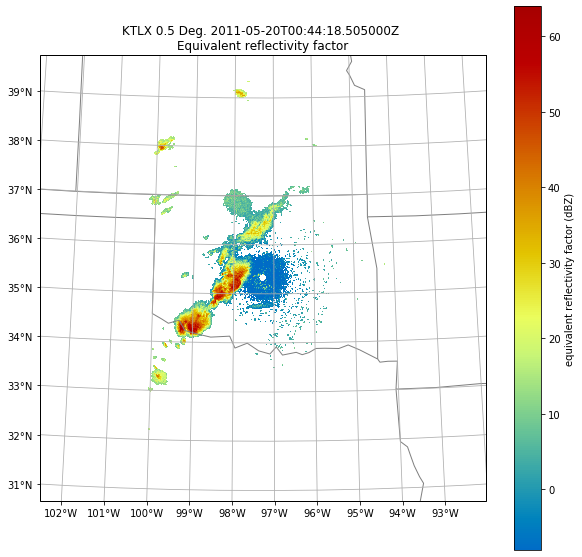

In [112]:
myf = plt.figure(figsize=[10,10])
myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64)

### Now this is the "Granule" of code which is applied to a single volume

In [118]:
def simple_sum(input_dict):
    #We use a dictionary as i
    #Fetch data from Amazon S3
    templocation = tempfile.mkdtemp()
    conn = nexradaws.NexradAwsInterface()
    scans = conn.get_avail_scans(input_dict['year'], 
                                 input_dict['month'], 
                                 input_dict['day'],
                                 input_dict['radar'])
    
    #What scan in the day do you want me to download?
    tscan = scans[input_dict['scan_number']]
    
    #dump to a local file
    localfiles = conn.download(tscan,templocation)
    
    #read into Py-ART
    this_dataset = pyart.io.read(localfiles.success[0].filepath)
    
    #Get the time so we know what time we are dealing with
    time_start = num2date(this_dataset.time['data'][0], this_dataset.time['units'])
    
    #Total number of radar gates
    tgates = float(this_dataset.ngates*this_dataset.nrays)
    
    #Get the reflectivity data
    zdat = this_dataset.fields['reflectivity']['data']
    
    #Fraction of gates above three levels
    z0 = float(len(np.where(zdat > 0.)[0]))/tgates
    z10 = float(len(np.where(zdat > 10.)[0]))/tgates
    z40 = float(len(np.where(zdat > 40.)[0]))/tgates
    
    #Grid the dataset
    grids = pyart.map.grid_from_radars(this_dataset,(31,301,301),
                   ((0.,15000.),(-150000.,150000.),(-150000.,150000.)),
                   fields=['reflectivity'],
                   refl_field='reflectivity', weighting_function='BARNES2')  
        
    z_prof_mean = grids.fields['reflectivity']['data'].mean(axis=(1,2))
    npts_over_10 = np.array([float(len(np.where(\
                      grids.fields['reflectivity']['data'][i, :, :] > 10.)[0]))\
                      for i in range(grids.fields['reflectivity']['data'].shape[0])])
    
    #Housekeeping
    del this_dataset, grids
    
    #return
    rv = (time_start, z0, z10, z40, z_prof_mean, npts_over_10)
    return rv

def simple_sum_error_catching(input_dict):
    #Wrapping our function in error catching 
    
    try:
        rv = simple_sum(input_dict)
    except (TypeError, KeyError) as e:
        rv = 'error'
    
    return rv

### Test to make sure it works on a granule

In [114]:
base_dict = {'year':'2011', 'month':'05', 'day':'20', 'radar':'KVNX'}
simple_sum(dict(base_dict, **{'scan_number' : 1}))

Downloaded KVNX20110520_000442_V06.gz
1 out of 1 files downloaded...0 errors


(datetime.datetime(2011, 5, 20, 0, 4, 42, 363000),
 0.06534495443326371,
 0.05331288367824821,
 0.002842844862139527,
 masked_array(data=[5.729805075721723, 5.412992029928432,
                    5.755818529445057, 6.595103593535075,
                    7.6120226160850635, 9.075649922685777,
                    10.63469814229494, 11.85573656940705,
                    12.662162574348026, 13.365382661208374,
                    14.17749035720275, 14.828638182452936,
                    15.154000398785634, 15.248870005704223,
                    15.075782675501777, 14.675680565932014,
                    14.094268875982234, 13.399851607122859,
                    12.63117097046601, 11.798975805378062,
                    10.945671021576006, 10.145710412452237,
                    9.52849470752733, 9.152601433801099, 9.038864657194647,
                    9.136843337829736, 9.211249656734863,
                    9.362404022259792, 9.509972282477705,
                    9.507344182010707, 

### Build a list for calling the function

In [119]:
n_scans_today = len(conn.get_avail_scans(base_dict['year'], 
                                 base_dict['month'], 
                                 base_dict['day'],
                                 base_dict['radar']))

call_list =[dict(base_dict, **{'scan_number' : i}) for i in range(n_scans_today)]

## Map the call_list list to the function and send to the cluster to execute

In [120]:
future = client.map(simple_sum_error_catching, call_list)

## Monitor progress

In [121]:
progress(future)

VBox()

## Reduce to get result

In [122]:
my_data = client.gather(future)

## Filter out tasks that returned an error

In [123]:
filtered_data = [value for value in my_data if type(value) != str]

In [134]:
times = np.array([tpl[0] for tpl in filtered_data])
z0 = np.array([tpl[1] for tpl in filtered_data])
z10 = np.array([tpl[2] for tpl in filtered_data])
z40 = np.array([tpl[3] for tpl in filtered_data])
zprof = np.array([tpl[4] for tpl in filtered_data])
npts_10 = np.array([tpl[5] for tpl in filtered_data])

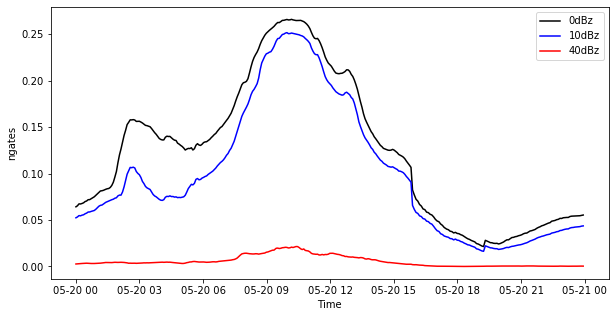

In [126]:
my_fig = plt.figure(figsize=[10,5])
plt.plot(times, z0, '-k', label='0dBz')
plt.plot(times, z10, '-b', label='10dBz')
plt.plot(times, z40, '-r', label='40dBz')
plt.ylabel('ngates')
plt.xlabel('Time')
plt.legend()

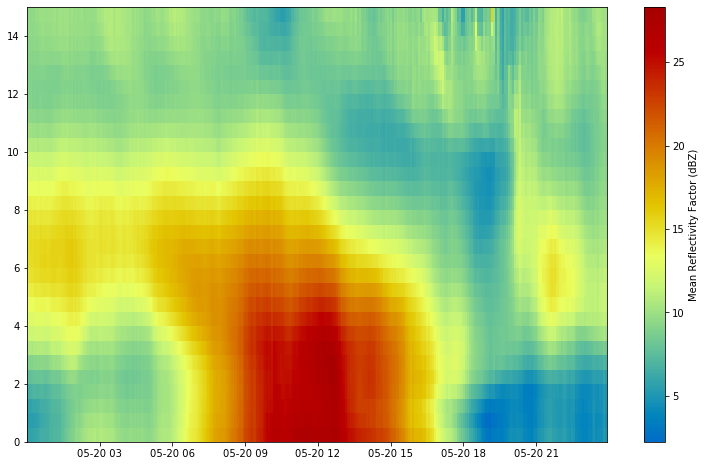

In [132]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(times, np.linspace(0,15,31), zprof.transpose(),
              cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar(label='Mean Reflectivity Factor (dBZ)')


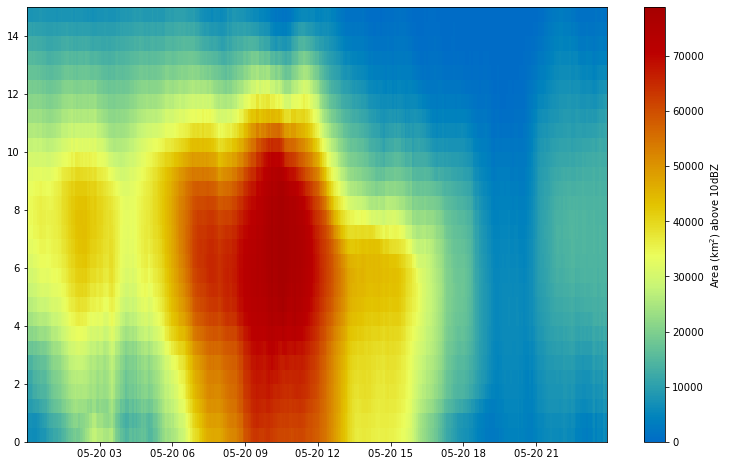

In [135]:
fig = plt.figure(figsize=[13,8])
plt.pcolormesh(times, np.linspace(0,15,31), npts_10.transpose(),
               cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
plt.colorbar(label='Area (km$^2$) above 10dBZ')

In [136]:
days = conn.get_avail_days(base_dict['year'], base_dict['month'])
new_call_list = []
for day in days:
    n_scans_today = len(conn.get_avail_scans(base_dict['year'], 
                                     base_dict['month'], 
                                     day,
                                     base_dict['radar']))
    
    call_list_today =[dict(base_dict, **{'scan_number' : i, 'day' : day}) for i in range(n_scans_today)]
    new_call_list.extend(call_list_today[:])

In [140]:
len(new_call_list)

6216

In [138]:
future = client.map(simple_sum_error_catching, new_call_list)


In [141]:
progress(future)

VBox()

In [65]:
my_data = client.gather(future)

In [66]:
filtered_data = [value for value in my_data if type(value) != str]

In [67]:
times = np.array([tpl[0] for tpl in filtered_data])
z0 = np.array([tpl[1] for tpl in filtered_data])
z10 = np.array([tpl[2] for tpl in filtered_data])
z40 = np.array([tpl[3] for tpl in filtered_data])

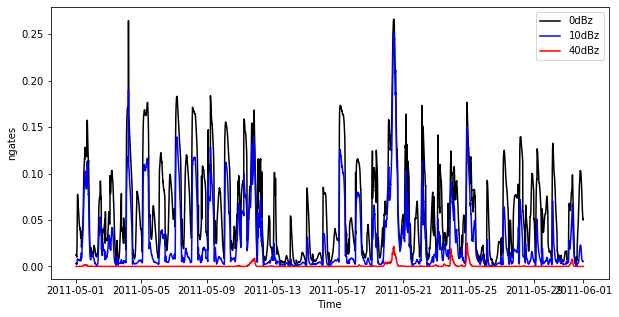

In [68]:

my_fig = plt.figure(figsize=[10,5])
plt.plot(times, z0, '-k', label='0dBz')
plt.plot(times, z10, '-b', label='10dBz')
plt.plot(times, z40, '-r', label='40dBz')
plt.ylabel('ngates')
plt.xlabel('Time')
plt.legend()

In [76]:
KubeCluster?

Init signature:
KubeCluster(
    pod_template=None,
    name=None,
    namespace=None,
    n_workers=None,
    host=None,
    port=None,
    env=None,
    auth=[<dask_kubernetes.auth.InCluster object at 0x7fbd15fe9d68>, <dask_kubernetes.auth.KubeConfig object at 0x7fbd15fe9e80>],
    **kwargs,
)
Docstring:     
Launch a Dask cluster on Kubernetes

This starts a local Dask scheduler and then dynamically launches
Dask workers on a Kubernetes cluster. The Kubernetes cluster is taken
to be either the current one on which this code is running, or as a
fallback, the default one configured in a kubeconfig file.

**Environments**

Your worker pod image should have a similar environment to your local
environment, including versions of Python, dask, cloudpickle, and any
libraries that you may wish to use (like NumPy, Pandas, or Scikit-Learn).
See examples below for suggestions on how to manage and check for this.

**Network**

Since the Dask scheduler is launched locally, for it to work, we need